In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, brier_score_loss, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set display options for better visualization
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Set random seed for reproducibility
RANDOM_STATE = 3
np.random.seed(RANDOM_STATE)

In [26]:
# Load datasets
df_tourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyDetailedResults.csv')
df_reg = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv')
df_seed = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv')
submission_sample = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage1.csv')

# Filter to more recent data (2015 and later)
def filter_time(df, season=2015):
    return df[df['Season'] >= season]

df_reg, df_tourney, df_seed = [filter_time(df) for df in [df_reg, df_tourney, df_seed]]

# Set identifiers and convert categorical data
identifiers = ['Season', 'WTeamID', 'LTeamID', 'DayNum']
df_reg['WLoc'] = df_reg['WLoc'].map({'A': 0, 'N': 1, 'H': 2})

# Add seed information to tournament data
df_tourney = df_tourney.merge(
    df_seed.rename(columns={'TeamID': 'WTeamID', 'Seed': 'WSeed'}),
    on=['Season', 'WTeamID'],
    how='left'
)

df_tourney = df_tourney.merge(
    df_seed.rename(columns={'TeamID': 'LTeamID', 'Seed': 'LSeed'}),
    on=['Season', 'LTeamID'],
    how='left'
)

# Helper function to extract seed number
def extract_seed_number(seed_str):
    if isinstance(seed_str, str) and len(seed_str) >= 2:
        return int(seed_str[1:3])
    return None

Regular Season Games: 57230
Tournament Games: 602
Seed Data: 612
Number of duplicated games: 0
Number of duplicated games: 0


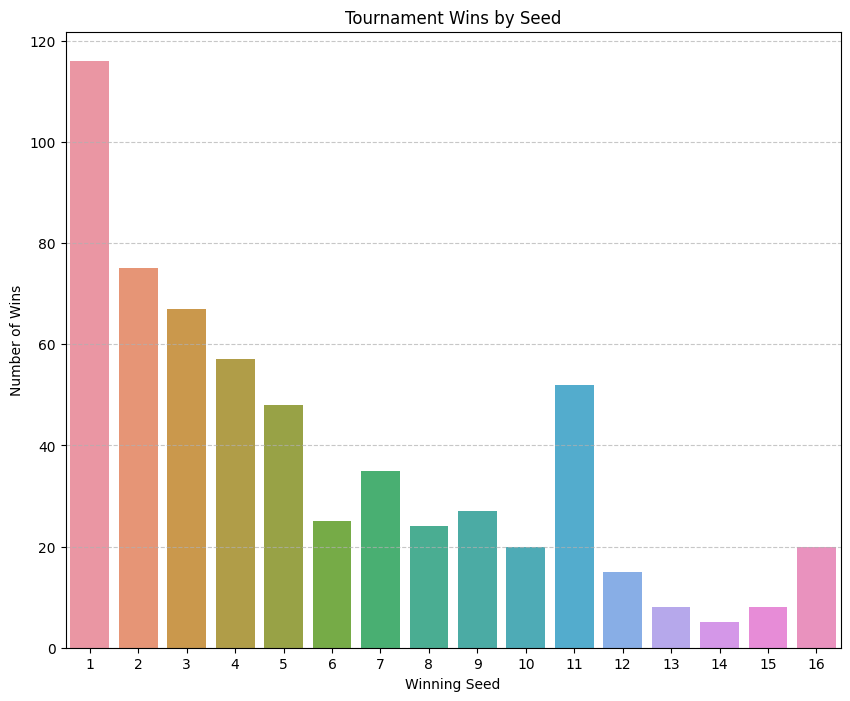

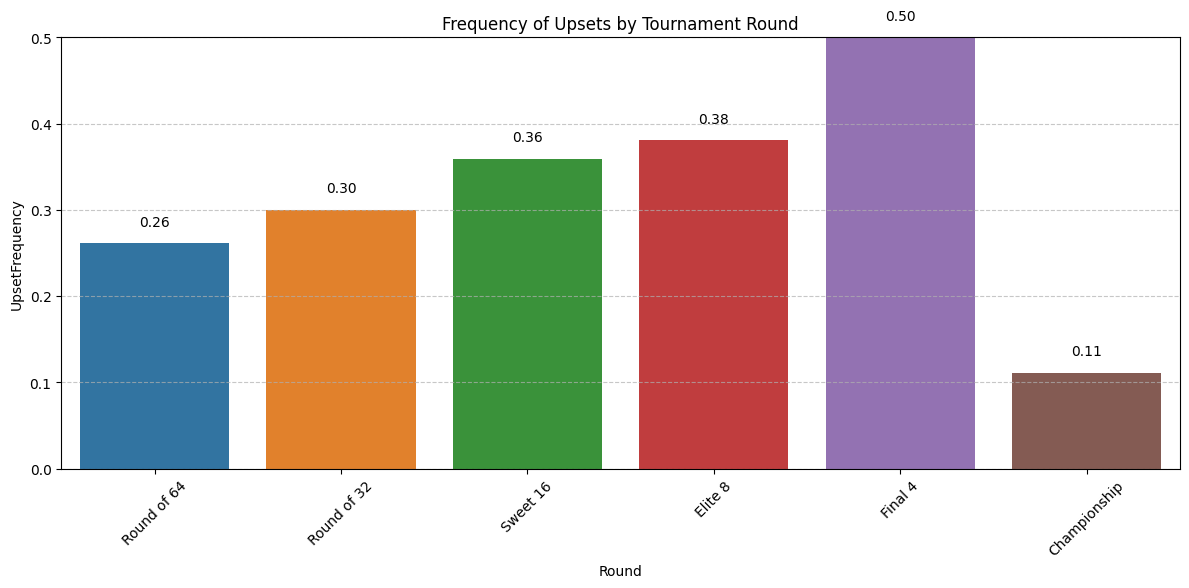

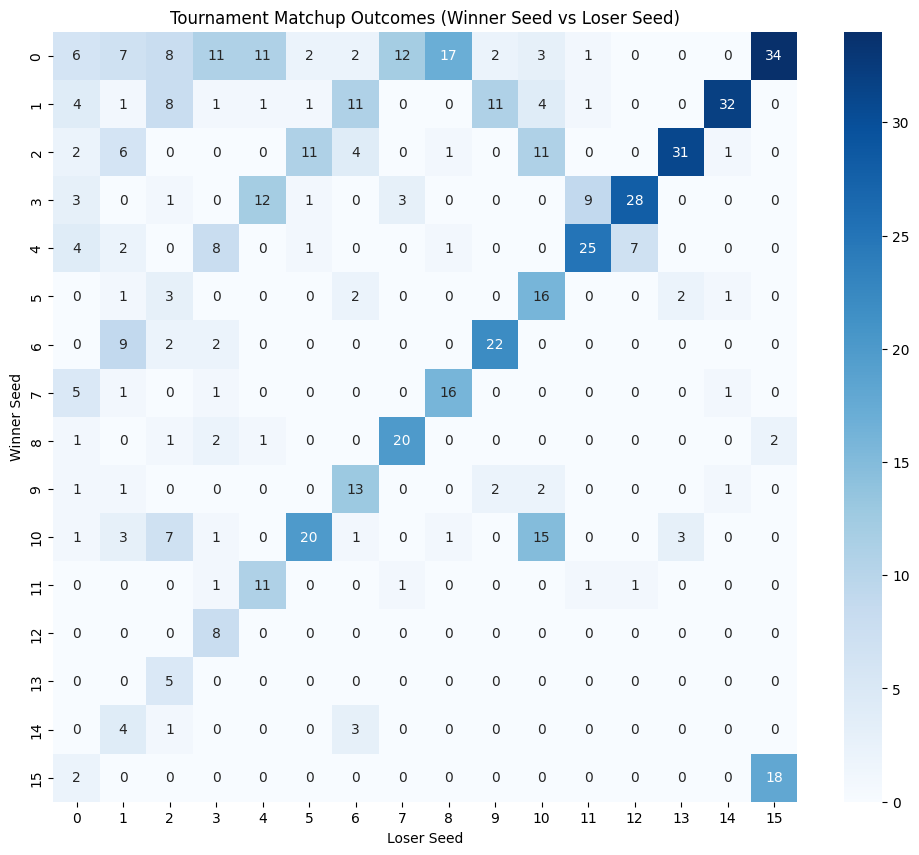

In [27]:
# Check dataset dimensions
print(f"Regular Season Games: {df_reg.shape[0]}")
print(f"Tournament Games: {df_tourney.shape[0]}")
print(f"Seed Data: {df_seed.shape[0]}")

# Function to check for duplicated games
def check_duplicated_games(df):
    # Create unique game identifiers
    df['game_id'] = df['Season'].astype(str) + '_' + df['DayNum'].astype(str) + '_' + \
                    df[['WTeamID', 'LTeamID']].min(axis=1).astype(str) + '_' + \
                    df[['WTeamID', 'LTeamID']].max(axis=1).astype(str)
    
    # Check for duplicates
    duplicates = df[df.duplicated('game_id')]
    print(f"Number of duplicated games: {len(duplicates)}")
    
    return df

df_tourney = check_duplicated_games(df_tourney)
df_reg = check_duplicated_games(df_reg)

# Clean up temporary game_id column
if 'game_id' in df_tourney.columns:
    df_tourney = df_tourney.drop('game_id', axis=1)
if 'game_id' in df_reg.columns:
    df_reg = df_reg.drop('game_id', axis=1)

# Add seed numbers as integers for analysis
df_tourney['WSeedNum'] = df_tourney['WSeed'].apply(extract_seed_number)
df_tourney['LSeedNum'] = df_tourney['LSeed'].apply(extract_seed_number)

# Analyze historical tournament outcomes by seed
plt.figure(figsize=(10, 8))
sns.countplot(data=df_tourney, x='WSeedNum', order=range(1, 17))
plt.title('Tournament Wins by Seed')
plt.xlabel('Winning Seed')
plt.ylabel('Number of Wins')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Define tournament rounds
df_tourney['Round'] = pd.cut(
    df_tourney['DayNum'], 
    bins=[134, 138, 141, 144, 147, 150, 154],
    labels=['Round of 64', 'Round of 32', 'Sweet 16', 'Elite 8', 'Final 4', 'Championship']
)

# Analyze upset frequency (when lower seed beats higher seed)
df_tourney['Upset'] = df_tourney['WSeedNum'] > df_tourney['LSeedNum']
upset_by_round = df_tourney.groupby('Round')['Upset'].agg(['mean', 'count'])
upset_by_round.columns = ['UpsetFrequency', 'TotalGames']

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=upset_by_round.index, y=upset_by_round['UpsetFrequency'])
plt.title('Frequency of Upsets by Tournament Round')
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels to bars
for i, v in enumerate(upset_by_round['UpsetFrequency']):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

# Seed Matchup Analysis
# Create a matrix of seed vs seed
seed_matrix = np.zeros((16, 16))
for i in range(len(df_tourney)):
    w_seed = df_tourney.iloc[i]['WSeedNum']
    l_seed = df_tourney.iloc[i]['LSeedNum']
    if pd.notna(w_seed) and pd.notna(l_seed):
        seed_matrix[int(w_seed)-1, int(l_seed)-1] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(seed_matrix, annot=True, fmt='.0f', cmap='Blues')
plt.title('Tournament Matchup Outcomes (Winner Seed vs Loser Seed)')
plt.xlabel('Loser Seed')
plt.ylabel('Winner Seed')
plt.show()

In [28]:
# Basic team statistics function
def engineer_features(df):
    """
    Creates advanced basketball statistics from basic box score data
    """
    for team in ['W', 'L']:
        # Calculate possessions (based on Dean Oliver's formula)
        df[f'{team}Possessions'] = (df[f'{team}FGA'] + (0.44*df[f'{team}FTA']) - df[f'{team}OR'] + df[f'{team}TO']).round()

    for team in ['W', 'L']:
        if team == 'W':
            opp_team = 'L'
        elif team == 'L':
            opp_team = 'W'
        
        # Shooting percentages
        df[f'{team}FGPct'] = df[f'{team}FGM']/df[f'{team}FGA']
        df[f'{team}FTPct'] = df[f'{team}FTM']/df[f'{team}FTA']
        df[f'{team}FG3Pct'] = df[f'{team}FGM3']/df[f'{team}FGA3']
        
        # Rebounding and ball handling
        df[f'{team}Reb'] = df[f'{team}OR'] + df[f'{team}DR']
        df[f'{team}ASTtoTOV'] = df[f'{team}Ast']/df[f'{team}TO']
        df[f'{team}TovRate'] = df[f'{team}TO']/df[f'{team}Possessions']
        
        # Efficiency metrics
        df[f'{team}OffEfficiency'] = df[f'{team}Score']/df[f'{team}Possessions']
        df[f'{team}eFGPct'] = (df[f'{team}FGM'] + (0.5*df[f'{team}FGM3']))/df[f'{team}FGA']
        
        # Rebounding percentages
        df[f'{team}ORPct'] = df[f'{team}OR']/(df[f'{team}OR'] + df[f'{opp_team}DR'])
        df[f'{team}DRPct'] = df[f'{team}DR']/(df[f'{team}DR'] + df[f'{opp_team}OR'])
        
        # Defensive metrics
        df[f'{team}StlRate'] = df[f'{team}Stl']/df[f'{opp_team}Possessions']
        df[f'{team}DefEfficiency'] = df[f'{opp_team}Score']/df[f'{opp_team}Possessions']
        
        # Point differential
        df[f'{team}ScoreMargin'] = df[f'{team}Score'] - df[f'{opp_team}Score']
    
    return df

# Apply feature engineering to both datasets
df_reg = engineer_features(df_reg)
df_tourney = engineer_features(df_tourney)

# Team profiles aggregation function
def aggregate_team_stats(df_regular):
    """
    Aggregate team stats for each season to create team profiles
    """
    # Process winning team stats
    w_cols = [col for col in df_regular.columns if col.startswith('W') and col not in ['WTeamID', 'WLoc']]
    w_cols_renamed = [col.replace('W', '') for col in w_cols]
    
    # Create DataFrame with winning team stats
    w_stats = df_regular[['Season', 'WTeamID', 'DayNum'] + w_cols].copy()
    w_stats.columns = ['Season', 'TeamID', 'DayNum'] + w_cols_renamed
    w_stats['Win'] = 1
    
    # Process losing team stats
    l_cols = [col for col in df_regular.columns if col.startswith('L') and col != 'LTeamID']
    l_cols_renamed = [col.replace('L', '') for col in l_cols]
    
    # Create DataFrame with losing team stats
    l_stats = df_regular[['Season', 'LTeamID', 'DayNum'] + l_cols].copy()
    l_stats.columns = ['Season', 'TeamID', 'DayNum'] + l_cols_renamed
    l_stats['Win'] = 0
    
    # Combine both DataFrames
    all_stats = pd.concat([w_stats, l_stats], ignore_index=True)
    
    # Sort by season, team, and day for proper momentum calculation
    all_stats = all_stats.sort_values(['Season', 'TeamID', 'DayNum'])
    
    # Group by Season and TeamID, then calculate mean for each stat
    team_avg_stats = all_stats.groupby(['Season', 'TeamID']).mean().reset_index()
    
    # Add win/loss records
    team_wins = df_regular.groupby(['Season', 'WTeamID']).size().reset_index()
    team_wins.columns = ['Season', 'TeamID', 'Wins']
    
    team_losses = df_regular.groupby(['Season', 'LTeamID']).size().reset_index()
    team_losses.columns = ['Season', 'TeamID', 'Losses']
    
    # Merge wins and losses to get records
    team_records = pd.merge(team_wins, team_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
    team_records['TotalGames'] = team_records['Wins'] + team_records['Losses']
    team_records['WinRate'] = team_records['Wins'] / team_records['TotalGames']
    
    # Merge avg stats with records
    team_profiles = pd.merge(team_avg_stats, team_records, on=['Season', 'TeamID'], how='left')
    
    return team_profiles, all_stats

In [29]:
# Calculate team profiles and get full game data
team_profiles, full_game_data = aggregate_team_stats(df_reg)

# Function to calculate momentum features (fixing data leakage with shift)
def calculate_momentum_features(game_data):
    """
    Calculate momentum features based on recent game performance
    Uses shift to avoid data leakage
    """
    # Sort by team and date
    game_data = game_data.sort_values(['Season', 'TeamID', 'DayNum'])
    
    # Calculate rolling averages with proper shifting
    momentum_window = 5
    
    # Win rate momentum - use shift(1) to avoid using current game in momentum
    game_data['WinRateMomentum'] = game_data.groupby(['Season', 'TeamID'])['Win'].transform(
        lambda x: x.shift(1).rolling(momentum_window, min_periods=1).mean()
    )
    
    # Score margin momentum
    game_data['ScoreMarginMomentum'] = game_data.groupby(['Season', 'TeamID'])['ScoreMargin'].transform(
        lambda x: x.shift(1).rolling(momentum_window, min_periods=1).mean()
    )
    
    # Offensive efficiency momentum
    game_data['OffEfficiencyMomentum'] = game_data.groupby(['Season', 'TeamID'])['OffEfficiency'].transform(
        lambda x: x.shift(1).rolling(momentum_window, min_periods=1).mean()
    )
    
    # Defensive efficiency momentum
    game_data['DefEfficiencyMomentum'] = game_data.groupby(['Season', 'TeamID'])['DefEfficiency'].transform(
        lambda x: x.shift(1).rolling(momentum_window, min_periods=1).mean()
    )
    
    # Replace NaN with team average for first games
    for col in ['WinRateMomentum', 'ScoreMarginMomentum', 'OffEfficiencyMomentum', 'DefEfficiencyMomentum']:
        game_data[col] = game_data.groupby(['Season', 'TeamID'])[col].transform(
            lambda x: x.fillna(x.mean())
        )
        # If still NaN (e.g., first season game), fill with neutral values
        if col == 'WinRateMomentum':
            game_data[col] = game_data[col].fillna(0.5)
        else:
            game_data[col] = game_data[col].fillna(0)
    
    return game_data

# Calculate tournament experience
def calculate_tournament_experience(tourney_data, current_season):
    """
    Calculate tournament experience for each team
    """
    # Filter to previous seasons
    past_tourneys = tourney_data[tourney_data['Season'] < current_season]
    
    # Get unique team appearances
    w_teams = past_tourneys[['Season', 'WTeamID']].rename(columns={'WTeamID': 'TeamID'})
    l_teams = past_tourneys[['Season', 'LTeamID']].rename(columns={'LTeamID': 'TeamID'})
    all_teams = pd.concat([w_teams, l_teams], ignore_index=True)
    
    # Count unique season appearances for each team
    tourney_exp = all_teams.groupby('TeamID').agg({'Season': 'nunique'}).reset_index()
    tourney_exp.columns = ['TeamID', 'TourneyAppearances']
    
    return tourney_exp

# Calculate strength of schedule
def calculate_strength_of_schedule(game_data, team_profiles):
    """
    Calculate strength of schedule as average opponent win rate
    """
    # Copy the data to avoid modifying the original
    game_data = game_data.copy()
    
    # Get opponent IDs for each game
    game_data['OpponentID'] = np.nan
    
    # For each team's games, determine the opponent
    for _, group in game_data.groupby(['Season', 'DayNum']):
        if len(group) == 2:  # Should be 2 rows for each game (one for each team)
            team_ids = group['TeamID'].values
            for i, team_id in enumerate(team_ids):
                opponent_id = team_ids[1-i]  # Get the other team ID
                game_data.loc[group.index[i], 'OpponentID'] = opponent_id
    
    # Drop rows where opponent couldn't be determined
    game_data = game_data.dropna(subset=['OpponentID'])
    game_data['OpponentID'] = game_data['OpponentID'].astype(int)
    
    # Merge opponent win rates from team profiles
    opponent_win_rates = team_profiles[['Season', 'TeamID', 'WinRate']].rename(
        columns={'TeamID': 'OpponentID', 'WinRate': 'OpponentWinRate'}
    )
    
    game_data = pd.merge(
        game_data,
        opponent_win_rates,
        on=['Season', 'OpponentID'],
        how='left'
    )
    
    # Calculate strength of schedule as average opponent win rate
    sos = game_data.groupby(['Season', 'TeamID'])['OpponentWinRate'].mean().reset_index()
    sos.columns = ['Season', 'TeamID', 'StrengthOfSchedule']
    
    # Fill NaN values with mean SOS
    mean_sos = sos['StrengthOfSchedule'].mean()
    sos['StrengthOfSchedule'] = sos['StrengthOfSchedule'].fillna(mean_sos)
    
    return sos

# Apply advanced feature engineering
momentum_data = calculate_momentum_features(full_game_data)

# Get most recent momentum values for each team in each season
latest_momentum = momentum_data.sort_values(['Season', 'TeamID', 'DayNum']).groupby(['Season', 'TeamID']).last().reset_index()
latest_momentum = latest_momentum[['Season', 'TeamID', 'WinRateMomentum', 'ScoreMarginMomentum', 
                                   'OffEfficiencyMomentum', 'DefEfficiencyMomentum']]

# Calculate strength of schedule
sos_data = calculate_strength_of_schedule(full_game_data, team_profiles)

# Examine our results
print("Team profiles sample:")
print(team_profiles[['Season', 'TeamID', 'Score', 'FGPct', 'OffEfficiency', 'DefEfficiency', 'WinRate']].head())

print("\nMomentum data sample:")
print(latest_momentum.head())

print("\nStrength of schedule sample:")
print(sos_data.head())

Team profiles sample:
   Season  TeamID      Score     FGPct  OffEfficiency  DefEfficiency   WinRate
0    2015    1101  61.000000  0.407501       0.944146       1.121063  0.250000
1    2015    1102  64.724138  0.467117       1.068001       1.081112  0.413793
2    2015    1103  67.352941  0.412920       1.046831       0.989083  0.588235
3    2015    1104  66.645161  0.440629       1.065089       1.030057  0.548387
4    2015    1105  61.285714  0.393334       0.957796       1.082599  0.285714

Momentum data sample:
   Season  TeamID  WinRateMomentum  ScoreMarginMomentum  \
0    2015    1101              0.2                 -8.8   
1    2015    1102              0.4                 -3.4   
2    2015    1103              0.6                  6.0   
3    2015    1104              0.4                 -1.4   
4    2015    1105              0.4                 -3.0   

   OffEfficiencyMomentum  DefEfficiencyMomentum  
0               0.934976               1.103649  
1               1.003860  

In [30]:
# Create tournament features for prediction
def create_matchup_features(team1_id, team2_id, season, team_profiles, seed_data, 
                           latest_momentum, sos_data):
    """
    Create features for tournament matchups
    """
    # Get team profiles
    team1_profile = team_profiles[(team_profiles['Season'] == season) & 
                                 (team_profiles['TeamID'] == team1_id)]
    
    team2_profile = team_profiles[(team_profiles['Season'] == season) & 
                                 (team_profiles['TeamID'] == team2_id)]
    
    # Check if teams exist in profiles
    if len(team1_profile) == 0 or len(team2_profile) == 0:
        return None
    
    team1_profile = team1_profile.iloc[0]
    team2_profile = team2_profile.iloc[0]
    
    # Get seeds
    team1_seed_row = seed_data[(seed_data['Season'] == season) & 
                             (seed_data['TeamID'] == team1_id)]
    
    team2_seed_row = seed_data[(seed_data['Season'] == season) & 
                             (seed_data['TeamID'] == team2_id)]
    
    # Check if seeds exist
    if len(team1_seed_row) == 0 or len(team2_seed_row) == 0:
        return None
    
    team1_seed = team1_seed_row['Seed'].values[0]
    team2_seed = team2_seed_row['Seed'].values[0]
    
    # Extract seed numbers
    team1_seed_num = extract_seed_number(team1_seed)
    team2_seed_num = extract_seed_number(team2_seed)
    
    # Get momentum data
    team1_momentum = latest_momentum[(latest_momentum['Season'] == season) & 
                                    (latest_momentum['TeamID'] == team1_id)]
    
    team2_momentum = latest_momentum[(latest_momentum['Season'] == season) & 
                                    (latest_momentum['TeamID'] == team2_id)]
    
    # If momentum data exists, get values, otherwise use defaults
    if len(team1_momentum) > 0:
        team1_win_momentum = team1_momentum['WinRateMomentum'].values[0]
        team1_score_momentum = team1_momentum['ScoreMarginMomentum'].values[0]
        team1_off_momentum = team1_momentum['OffEfficiencyMomentum'].values[0]
        team1_def_momentum = team1_momentum['DefEfficiencyMomentum'].values[0]
    else:
        team1_win_momentum = team1_profile['WinRate']
        team1_score_momentum = 0
        team1_off_momentum = team1_profile['OffEfficiency']
        team1_def_momentum = team1_profile['DefEfficiency']
    
    if len(team2_momentum) > 0:
        team2_win_momentum = team2_momentum['WinRateMomentum'].values[0]
        team2_score_momentum = team2_momentum['ScoreMarginMomentum'].values[0]
        team2_off_momentum = team2_momentum['OffEfficiencyMomentum'].values[0]
        team2_def_momentum = team2_momentum['DefEfficiencyMomentum'].values[0]
    else:
        team2_win_momentum = team2_profile['WinRate']
        team2_score_momentum = 0
        team2_off_momentum = team2_profile['OffEfficiency']
        team2_def_momentum = team2_profile['DefEfficiency']
    
    # Get strength of schedule
    team1_sos = sos_data[(sos_data['Season'] == season) & 
                       (sos_data['TeamID'] == team1_id)]
    
    team2_sos = sos_data[(sos_data['Season'] == season) & 
                       (sos_data['TeamID'] == team2_id)]
    
    # If SOS data exists, get values, otherwise use mean
    mean_sos = sos_data['StrengthOfSchedule'].mean()
    
    if len(team1_sos) > 0:
        team1_sos_val = team1_sos['StrengthOfSchedule'].values[0]
    else:
        team1_sos_val = mean_sos
    
    if len(team2_sos) > 0:
        team2_sos_val = team2_sos['StrengthOfSchedule'].values[0]
    else:
        team2_sos_val = mean_sos
    
    # Create feature dictionary
    feature_dict = {
        'Season': season,
        'Team1ID': team1_id,
        'Team2ID': team2_id,
        'Team1Seed': team1_seed_num,
        'Team2Seed': team2_seed_num,
        'SeedDiff': team1_seed_num - team2_seed_num,
        'Team1WinRate': team1_profile['WinRate'],
        'Team2WinRate': team2_profile['WinRate'],
        'WinRateDiff': team1_profile['WinRate'] - team2_profile['WinRate'],
        'Team1WinRateMomentum': team1_win_momentum,
        'Team2WinRateMomentum': team2_win_momentum,
        'WinRateMomentumDiff': team1_win_momentum - team2_win_momentum,
        'Team1ScoreMomentum': team1_score_momentum,
        'Team2ScoreMomentum': team2_score_momentum,
        'ScoreMomentumDiff': team1_score_momentum - team2_score_momentum,
        'Team1OffMomentum': team1_off_momentum,
        'Team2OffMomentum': team2_off_momentum,
        'OffMomentumDiff': team1_off_momentum - team2_off_momentum,
        'Team1DefMomentum': team1_def_momentum,
        'Team2DefMomentum': team2_def_momentum,
        'DefMomentumDiff': team1_def_momentum - team2_def_momentum,
        'Team1SOS': team1_sos_val,
        'Team2SOS': team2_sos_val,
        'SOSDiff': team1_sos_val - team2_sos_val
    }
    
    # Add core team metrics
    for stat in ['OffEfficiency', 'DefEfficiency', 'FGPct', 'FG3Pct', 'FTPct', 
                'ORPct', 'DRPct', 'ASTtoTOV', 'StlRate', 'TovRate']:
        if stat in team1_profile and stat in team2_profile:
            feature_dict[f'Team1{stat}'] = team1_profile[stat]
            feature_dict[f'Team2{stat}'] = team2_profile[stat]
            feature_dict[f'{stat}Diff'] = team1_profile[stat] - team2_profile[stat]
    
    return feature_dict

def create_tournament_features(tourney_data, team_profiles, seed_data, 
                              latest_momentum, sos_data):
    """
    Create features for all tournament matchups
    """
    features = []
    
    for _, row in tourney_data.iterrows():
        season = row['Season']
        team1_id = row['WTeamID']
        team2_id = row['LTeamID']
        
        # Get features for this matchup
        feature_dict = create_matchup_features(
            team1_id, team2_id, season, team_profiles, seed_data,
            latest_momentum, sos_data
        )
        
        if feature_dict:
            features.append(feature_dict)
    
    return pd.DataFrame(features)

# Create tournament features dataset
tourney_features = create_tournament_features(
    df_tourney, team_profiles, df_seed, latest_momentum, sos_data
)

# Display feature dataset
print(f"Tournament features dataset shape: {tourney_features.shape}")
print("Sample of tournament features:")
print(tourney_features.iloc[:3, :10])  # Show first 3 rows, first 10 columns

Tournament features dataset shape: (602, 54)
Sample of tournament features:
   Season  Team1ID  Team2ID  Team1Seed  Team2Seed  SeedDiff  Team1WinRate  \
0    2015     1214     1264         16         16         0      0.484848   
1    2015     1279     1140         11         11         0      0.625000   
2    2015     1173     1129         11         11         0      0.757576   

   Team2WinRate  WinRateDiff  Team1WinRateMomentum  
0      0.593750    -0.108902                   0.6  
1      0.718750    -0.093750                   0.4  
2      0.741935     0.015640                   0.8  


In [32]:
def train_tournament_model(features_df, test_season=None):
    """
    Train model for tournament predictions with proper cross-validation
    """
    # Create a copy of the original dataframe
    features_df_copy = features_df.copy()
    
    # Create target variable (1 for Team1 win)
    features_df_copy['Target'] = 1
    
    # Create flipped version (swap Team1 and Team2)
    flipped_df = features_df_copy.copy()
    
    # Swap Team IDs
    flipped_df['Team1ID'], flipped_df['Team2ID'] = flipped_df['Team2ID'], flipped_df['Team1ID']
    
    # Swap features
    for col in features_df_copy.columns:
        if col.startswith('Team1'):
            # Find the corresponding Team2 column
            team2_col = 'Team2' + col[5:]
            if team2_col in features_df_copy.columns:
                flipped_df[col], flipped_df[team2_col] = flipped_df[team2_col], flipped_df[col]
        
        # Flip difference columns
        if col.endswith('Diff') and not col.startswith('Team'):
            flipped_df[col] = -flipped_df[col]
    
    # Set the target for flipped matchups to 0 (Team1 loses)
    flipped_df['Target'] = 0
    
    # Combine original and flipped dataframes
    balanced_df = pd.concat([features_df_copy, flipped_df], ignore_index=True)
    
    # Define features to use (exclude identifiers and target)
    feature_cols = [col for col in balanced_df.columns if col not in 
                   ['Season', 'Team1ID', 'Team2ID', 'Target']]
    
    # Split data based on test_season
    if test_season:
        train_df = balanced_df[balanced_df['Season'] < test_season]
        test_df = balanced_df[balanced_df['Season'] >= test_season]
        
        X_train = train_df[feature_cols]
        y_train = train_df['Target']
        X_test = test_df[feature_cols]
        y_test = test_df['Target']
        
        print(f"Training on seasons before {test_season}, testing on {test_season}")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    else:
        # If no test_season, use random split (with stratification)
        X = balanced_df[feature_cols]
        y = balanced_df['Target']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        
        print(f"Using random split: Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=200, 
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Use calibration to ensure well-calibrated probabilities for Brier score
    calibrated_rf = CalibratedClassifierCV(
        rf_model, 
        method='sigmoid', 
        cv=5
    )
    
    print("Training Random Forest model...")
    calibrated_rf.fit(X_train_scaled, y_train)
    
    # Train XGBoost model
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    print("Training XGBoost model...")
    xgb_model.fit(X_train_scaled, y_train)
    
    # Evaluate models
    print("\nModel Evaluation")
    print("-" * 50)
    
    models = {
        'Random Forest': calibrated_rf,
        'XGBoost': xgb_model
    }
    
    best_model = None
    best_score = float('inf')  # Lower is better for Brier score
    
    predictions = {}
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Store predictions
        predictions[name] = y_pred_proba
        
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        loss = log_loss(y_test, y_pred_proba)
        brier = brier_score_loss(y_test, y_pred_proba)
        
        print(f"{name} Results:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  AUC: {auc:.4f}")
        print(f"  Log Loss: {loss:.4f}")
        print(f"  Brier Score: {brier:.4f}")
        
        # Check if this is the best model based on Brier score
        if brier < best_score:
            best_score = brier
            best_model = model
    
    # Create ensemble prediction by averaging
    ensemble_pred_proba = np.mean(list(predictions.values()), axis=0)
    ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)
    
    # Calculate ensemble metrics
    ensemble_acc = accuracy_score(y_test, ensemble_pred)
    ensemble_auc = roc_auc_score(y_test, ensemble_pred_proba)
    ensemble_loss = log_loss(y_test, ensemble_pred_proba)
    ensemble_brier = brier_score_loss(y_test, ensemble_pred_proba)
    
    print("\nEnsemble Model Results:")
    print(f"  Accuracy: {ensemble_acc:.4f}")
    print(f"  AUC: {ensemble_auc:.4f}")
    print(f"  Log Loss: {ensemble_loss:.4f}")
    print(f"  Brier Score: {ensemble_brier:.4f}")
    
    # If ensemble is better, use it as best model
    if ensemble_brier < best_score:
        print("\nEnsemble is the best model!")
        # Since ensemble doesn't have a single model object, we'll return both models
        return models, scaler, feature_cols, True
    else:
        # Find which model was best
        for name, model in models.items():
            brier = brier_score_loss(y_test, predictions[name])
            if brier == best_score:
                print(f"\n{name} is the best model!")
                break
        
        return models, scaler, feature_cols, False

In [33]:
# Use 2023 as test season to validate our model
models, scaler, feature_cols, use_ensemble = train_tournament_model(tourney_features, test_season=2021)

# Get feature importance for Random Forest model
rf_model = models['Random Forest']

if hasattr(rf_model, 'estimators_'):
    # CalibratedClassifierCV has the original model in estimators_
    base_rf = rf_model.estimators_[0]
else:
    base_rf = rf_model

if hasattr(base_rf, 'feature_importances_'):
    # Create feature importance DataFrame
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': base_rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance.head(20))
    plt.title('Top 20 Features by Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

Training on seasons before 2021, testing on 2021
Train size: 670, Test size: 534
Training Random Forest model...
Training XGBoost model...

Model Evaluation
--------------------------------------------------
Random Forest Results:
  Accuracy: 0.6704
  AUC: 0.7257
  Log Loss: 0.6126
  Brier Score: 0.2121
XGBoost Results:
  Accuracy: 0.6423
  AUC: 0.7013
  Log Loss: 0.7446
  Brier Score: 0.2455

Ensemble Model Results:
  Accuracy: 0.6685
  AUC: 0.7150
  Log Loss: 0.6434
  Brier Score: 0.2232

Random Forest is the best model!


In [34]:
def predict_tournament_matchup(team1_id, team2_id, season, models, scaler, feature_cols,
                              team_profiles, seed_data, latest_momentum, sos_data, use_ensemble=True):
    """
    Predict the probability of team1 winning against team2
    """
    # Create features for this matchup
    feature_dict = create_matchup_features(
        team1_id, team2_id, season, team_profiles, seed_data,
        latest_momentum, sos_data
    )
    
    if not feature_dict:
        # If we couldn't create features, return 0.5 (uncertain)
        return 0.5
    
    # Create DataFrame with just the needed features
    X = pd.DataFrame([{col: feature_dict[col] for col in feature_cols if col in feature_dict}])
    
    # Handle missing features by filling with 0
    for col in feature_cols:
        if col not in X.columns:
            X[col] = 0
    
    # Ensure features are in the right order
    X = X[feature_cols]
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Make predictions with all models
    predictions = []
    for name, model in models.items():
        pred = model.predict_proba(X_scaled)[0, 1]
        predictions.append(pred)
    
    # Use ensemble or best model
    if use_ensemble:
        return np.mean(predictions)
    else:
        # Return prediction from best model (first model)
        return predictions[0]

def generate_submission(submission_df, models, scaler, feature_cols, 
                       team_profiles, seed_data, latest_momentum, sos_data, use_ensemble=True):
    """
    Generate submission file with predictions for all matchups
    """
    predictions = []
    
    for i, row in submission_df.iterrows():
        # Parse the ID to get team info
        parts = row['ID'].split('_')
        season = int(parts[0])
        team1_id = int(parts[1])
        team2_id = int(parts[2])
        
        # Get prediction for this matchup
        prob = predict_tournament_matchup(
            team1_id, team2_id, season, models, scaler, feature_cols,
            team_profiles, seed_data, latest_momentum, sos_data, use_ensemble
        )
        
        predictions.append({'ID': row['ID'], 'Pred': prob})
        
        # Show progress
        if i % 10000 == 0:
            print(f"Processed {i} of {len(submission_df)} predictions")
    
    # Create submission DataFrame
    submission = pd.DataFrame(predictions)
    return submission

# Generate submission (using a small sample for demonstration)
submission_sample_small = submission_sample.head(100)
sample_submission = generate_submission(
    submission_sample_small, models, scaler, feature_cols,
    team_profiles, df_seed, latest_momentum, sos_data, use_ensemble
)

print("\nSample submission preview:")
print(sample_submission.head())

# Uncomment to generate full submission
# full_submission = generate_submission(
#     submission_sample, models, scaler, feature_cols,
#     team_profiles, df_seed, latest_momentum, sos_data, use_ensemble
# )
# 
# full_submission.to_csv('march_madness_submission.csv', index=False)

Processed 0 of 100 predictions

Sample submission preview:
               ID      Pred
0  2021_1101_1102  0.500000
1  2021_1101_1103  0.500000
2  2021_1101_1104  0.389244
3  2021_1101_1105  0.500000
4  2021_1101_1106  0.500000


Random Forest Confusion Matrix:


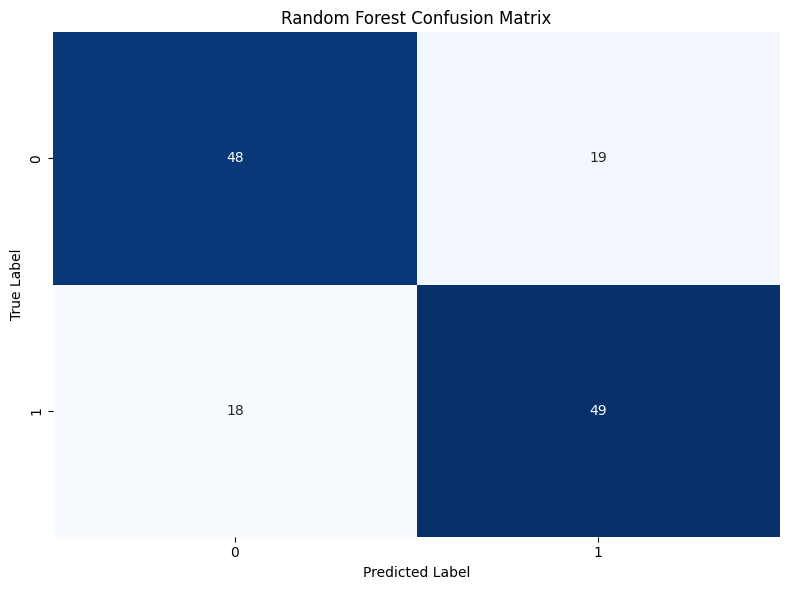

XGBoost Confusion Matrix:


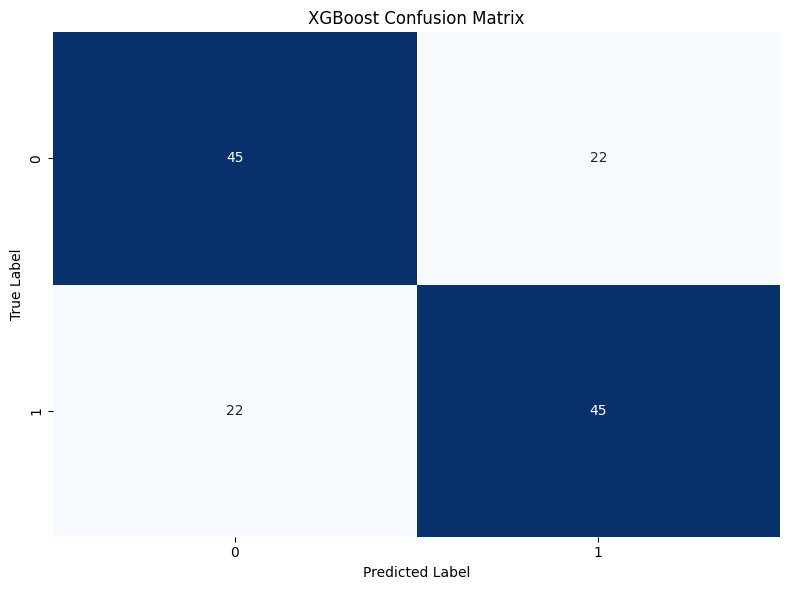

Ensemble Confusion Matrix:


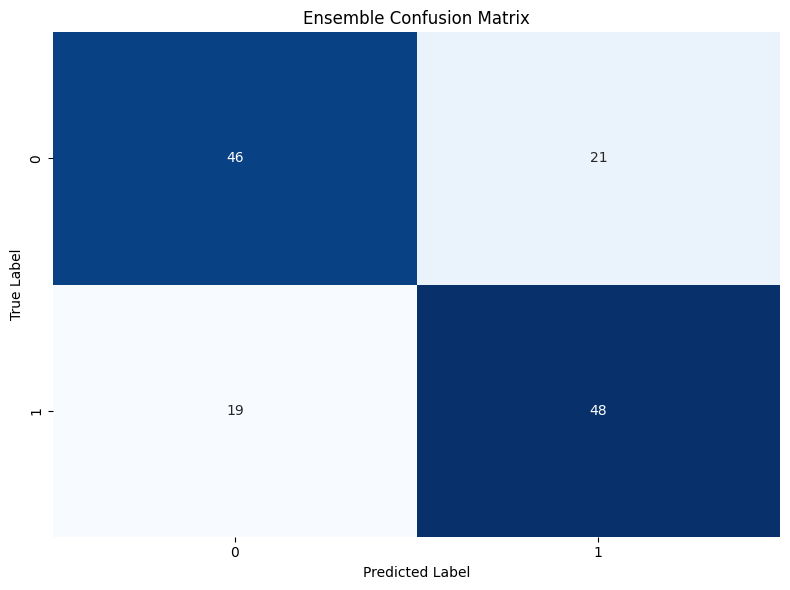

Random Forest ROC Curve:


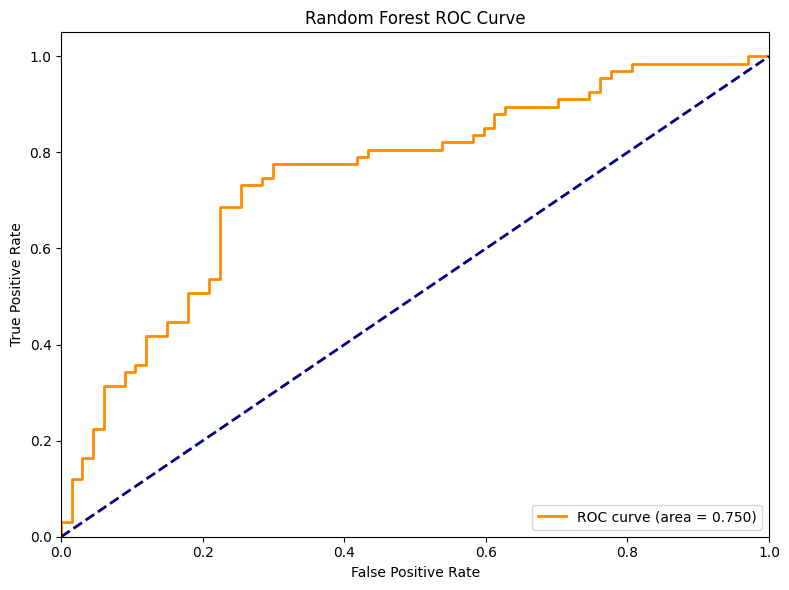

XGBoost ROC Curve:


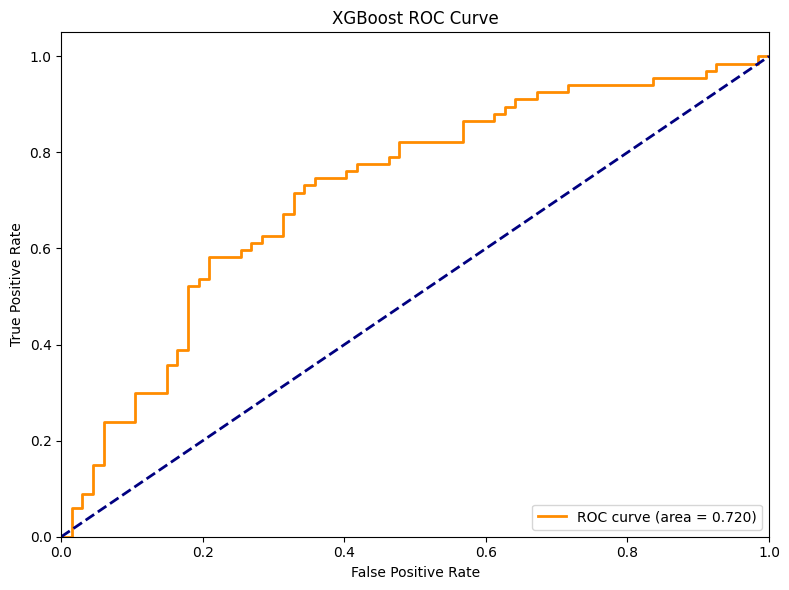

Ensemble ROC Curve:


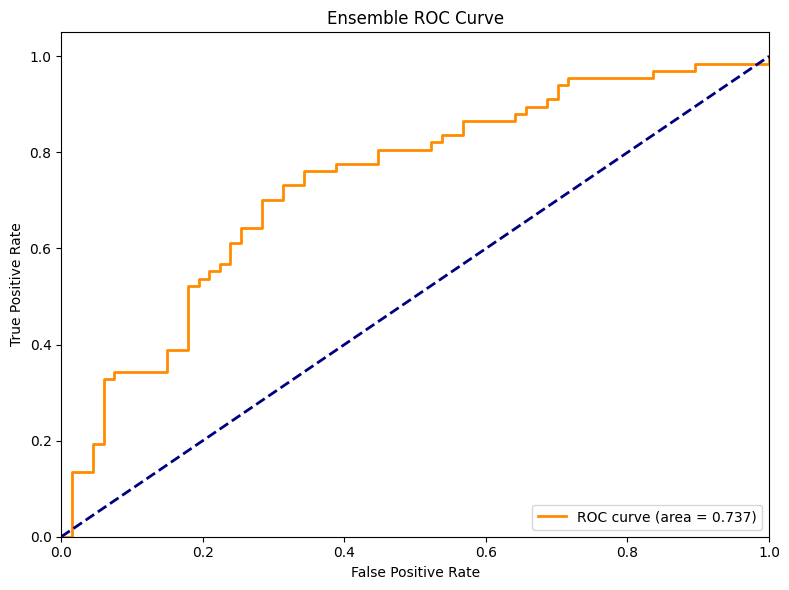

Random Forest Brier Score: 0.2019
XGBoost Brier Score: 0.2311
Ensemble Brier Score: 0.2109


In [37]:
# Helper function to create confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Helper function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Create a small validation set for visualization
# Use the 2023 season data
val_season = 2023
val_features = tourney_features[tourney_features['Season'] == val_season].copy()

if len(val_features) > 0:
    # Create target
    val_features['Target'] = 1
    
    # Create flipped version
    val_flipped = val_features.copy()
    
    # Swap Team IDs
    val_flipped['Team1ID'], val_flipped['Team2ID'] = val_flipped['Team2ID'], val_flipped['Team1ID']
    
    # Swap features
    for col in val_features.columns:
        if col.startswith('Team1'):
            team2_col = 'Team2' + col[5:]
            if team2_col in val_features.columns:
                val_flipped[col], val_flipped[team2_col] = val_flipped[team2_col], val_flipped[col]
        
        # Flip difference columns
        if col.endswith('Diff') and not col.startswith('Team'):
            val_flipped[col] = -val_flipped[col]
    
    # Set target for flipped matchups
    val_flipped['Target'] = 0
    
    # Combine
    val_balanced = pd.concat([val_features, val_flipped], ignore_index=True)
    
    # Extract features and target
    X_val = val_balanced[feature_cols]
    y_val = val_balanced['Target']
    
    # Scale features
    X_val_scaled = scaler.transform(X_val)
    
    # Get predictions from each model
    rf_pred_proba = models['Random Forest'].predict_proba(X_val_scaled)[:, 1]
    xgb_pred_proba = models['XGBoost'].predict_proba(X_val_scaled)[:, 1]
    
    # Ensemble predictions
    ensemble_pred_proba = (rf_pred_proba + xgb_pred_proba) / 2
    
    # Convert to binary predictions
    rf_pred = (rf_pred_proba > 0.5).astype(int)
    xgb_pred = (xgb_pred_proba > 0.5).astype(int)
    ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)
    
    # Plot confusion matrices
    print("Random Forest Confusion Matrix:")
    plot_confusion_matrix(y_val, rf_pred, "Random Forest Confusion Matrix")
    
    print("XGBoost Confusion Matrix:")
    plot_confusion_matrix(y_val, xgb_pred, "XGBoost Confusion Matrix")
    
    print("Ensemble Confusion Matrix:")
    plot_confusion_matrix(y_val, ensemble_pred, "Ensemble Confusion Matrix")
    
    # Plot ROC curves
    print("Random Forest ROC Curve:")
    plot_roc_curve(y_val, rf_pred_proba, "Random Forest ROC Curve")
    
    print("XGBoost ROC Curve:")
    plot_roc_curve(y_val, xgb_pred_proba, "XGBoost ROC Curve")
    
    print("Ensemble ROC Curve:")
    plot_roc_curve(y_val, ensemble_pred_proba, "Ensemble ROC Curve")
    
    # Calculate Brier scores
    rf_brier = brier_score_loss(y_val, rf_pred_proba)
    xgb_brier = brier_score_loss(y_val, xgb_pred_proba)
    ensemble_brier = brier_score_loss(y_val, ensemble_pred_proba)
    
    print(f"Random Forest Brier Score: {rf_brier:.4f}")
    print(f"XGBoost Brier Score: {xgb_brier:.4f}")
    print(f"Ensemble Brier Score: {ensemble_brier:.4f}")